In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import dask
import dask.dataframe as dd
from py2neo import Graph, Node, Relationship
from matplotlib import pyplot as plt
import heapq
graph = Graph('http://localhost:11006', auth=('neo4j','paneru'))
plt.rcParams['figure.figsize'] = [25, 10]
graph = Graph("bolt://localhost:7687", auth=("neo4j", "1234"))

In [24]:
pp = 0 #preprocessing flag
if pp == 1:
    graph.run('''USING PERIODIC COMMIT 1000 LOAD CSV WITH HEADERS FROM 'file:///soc-redditHyperlinks-body.tsv' AS row FIELDTERMINATOR '\t' 
MERGE(sr:SubReddit{id: row['SOURCE_SUBREDDIT']}) 
MERGE(tr:SubReddit{id:row['TARGET_SUBREDDIT']}) 
MERGE(p: POST{id: row['POST_ID'], sentiment: toInteger(row['LINK_SENTIMENT']),textProp: [x in split(row['PROPERTIES'],',') | toFloat(x)]})
MERGE(hr: HourNode{id: datetime({ epochMillis:apoc.date.parse(row['TIMESTAMP'], 'ms', 'yyyy-mm-dd HH:mm:ss')}).hour})
MERGE(yr: YearNode{id: datetime({ epochMillis:apoc.date.parse(row['TIMESTAMP'], 'ms', 'yyyy-mm-dd HH:mm:ss')}).year})
MERGE(yr: DayNode{id: datetime({ epochMillis:apoc.date.parse(row['TIMESTAMP'], 'ms', 'yyyy-mm-dd HH:mm:ss')}).dayOfWeek})
RETURN count(sr)''')
    graph.run('''USING PERIODIC COMMIT 1000 LOAD CSV WITH HEADERS FROM 'file:///soc-redditHyperlinks-body.tsv' AS row FIELDTERMINATOR '\t' 
MATCH(sr:SubReddit{id: row['SOURCE_SUBREDDIT']}) 
MATCH(tr:SubReddit{id:row['TARGET_SUBREDDIT']}) 
MERGE(sr)-[rel:targets {id: row['POST_ID'], sentiment: toInteger(row['LINK_SENTIMENT']),textProp: [x in split(row['PROPERTIES'],',') | toFloat(x)], timestamp: datetime({ epochMillis:apoc.date.parse(row['TIMESTAMP'], 'ms', 'yyyy-mm-dd HH:mm:ss') })}]->(tr) 
RETURN count(rel)''')
    graph.run('''USING PERIODIC COMMIT 1000 LOAD CSV WITH HEADERS FROM 'file:///soc-redditHyperlinks-body.tsv' AS row FIELDTERMINATOR '\t' 
MATCH(sr:SubReddit{id: row['SOURCE_SUBREDDIT']}) 
MATCH(tr:SubReddit{id:row['TARGET_SUBREDDIT']}) 
MATCH(p: POST{id: row['POST_ID']})
MERGE(sr)-[:target_by{sentiment: p.sentiment}]->(p)-[:target_to{sentiment: p.sentiment}]->(tr)
RETURN count(sr)''')
    graph.run('''USING PERIODIC COMMIT 1000 LOAD CSV WITH HEADERS FROM 'file:///soc-redditHyperlinks-body.tsv' AS row FIELDTERMINATOR '\t'
MATCH(hr: HourNode{id: datetime({ epochMillis:apoc.date.parse(row['TIMESTAMP'], 'ms', 'yyyy-mm-dd HH:mm:ss')}).hour})
MATCH(p:POST{id:row['POST_ID']})
MERGE(hr)-[:POSTED_AT]->(p)
RETURN count(hr)
''')
    graph.run('''USING PERIODIC COMMIT 1000 LOAD CSV WITH HEADERS FROM 'file:///soc-redditHyperlinks-body.tsv' AS row FIELDTERMINATOR '\t'
MATCH(hr: HourNode{id: datetime({ epochMillis:apoc.date.parse(row['TIMESTAMP'], 'ms', 'yyyy-mm-dd HH:mm:ss')}).hour})
MATCH(p:POST{id:row['POST_ID']})
MERGE(hr)-[:POSTED_AT]->(p)
RETURN count(hr)
''')
    graph.run('''USING PERIODIC COMMIT 1000 LOAD CSV WITH HEADERS FROM 'file:///soc-redditHyperlinks-body.tsv' AS row FIELDTERMINATOR '\t'
MATCH(yr: YearNode{id: datetime({ epochMillis:apoc.date.parse(row['TIMESTAMP'], 'ms', 'yyyy-mm-dd HH:mm:ss')}).year})
MATCH(p:POST{id:row['POST_ID']})
MERGE(yr)-[:POSTED_AT]->(p)
RETURN count(yr)
''')

In [5]:
row=graph.run("match (s1:SubReddit)-[r:targets{sentiment:-1}]->()  return s1.id, count(r.sentiment) as num order by num DESC limit 1000").to_data_frame()
df=pd.DataFrame(row)
ddf = dd.from_pandas(df, npartitions=8)
row1=graph.run("match (s1:SubReddit)-[r:targets{sentiment:1}]->()  return s1.id, count(r.sentiment) as num order by num DESC limit 1000").to_data_frame()
df1=pd.DataFrame(row1)
ddf1 = dd.from_pandas(df1, npartitions=8)


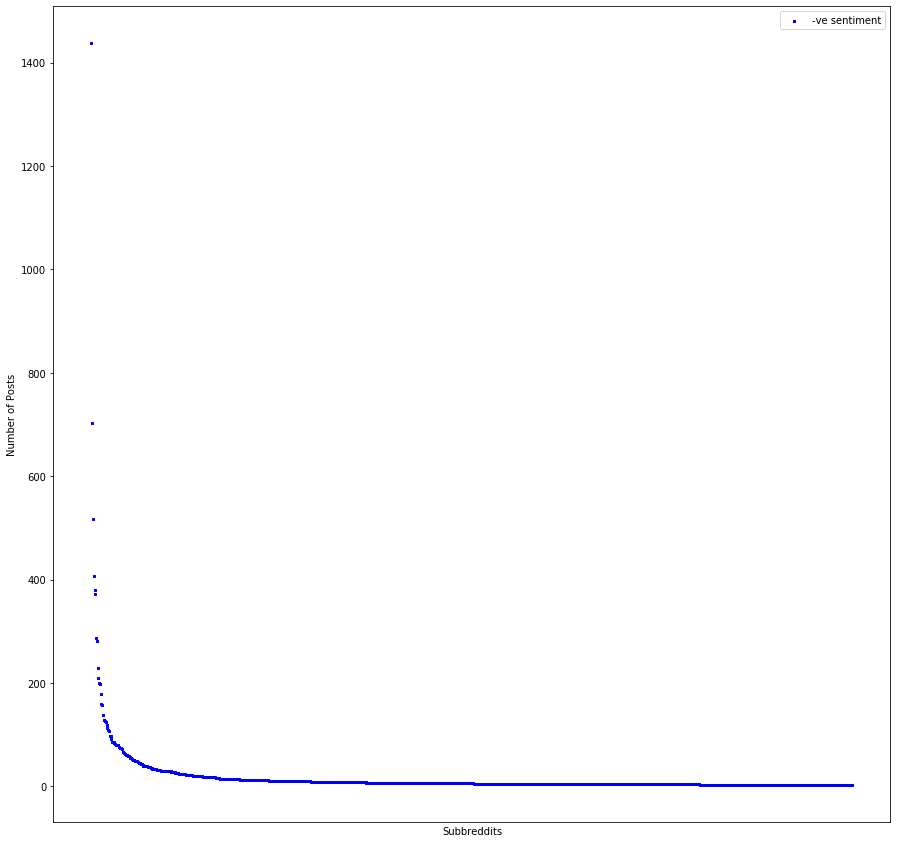

In [6]:
plt.rcParams['figure.figsize'] = [15,15]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(df['s1.id'], df['num'], s=6, c='b', marker="s", label='-ve sentiment')
#ax1.scatter(df1['s1.id'],df1['num'], s=6, c='r', marker="o", label='+ve sentiment')
plt.legend(loc='upper right');

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel("Subbreddits")
plt.ylabel("Number of Posts")
plt.show()
fig.savefig('-ve.png')

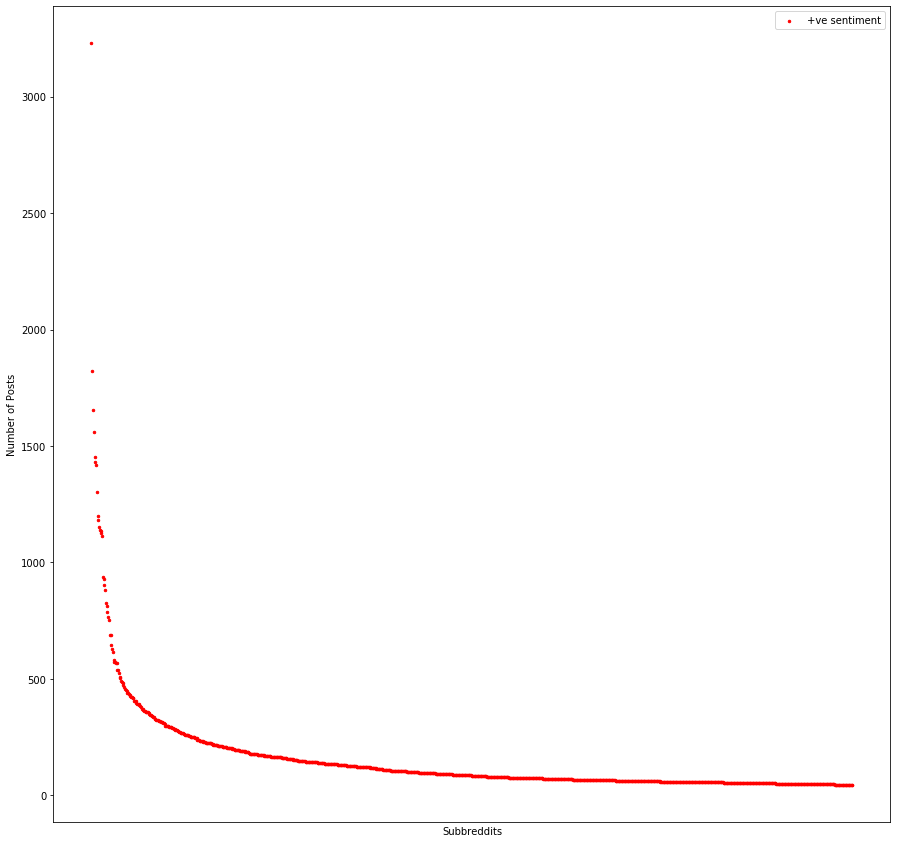

In [7]:
plt.rcParams['figure.figsize'] = [15,15]
fig = plt.figure()
ax1 = fig.add_subplot(111)

#ax1.scatter(df['s1.id'], df['num'], s=6, c='b', marker="s", label='-ve sentiment')
ax1.scatter(df1['s1.id'],df1['num'], s=6, c='r', marker="o", label='+ve sentiment')
plt.legend(loc='upper right');

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel("Subbreddits")
plt.ylabel("Number of Posts")
plt.show()
fig.savefig('+ve.png')

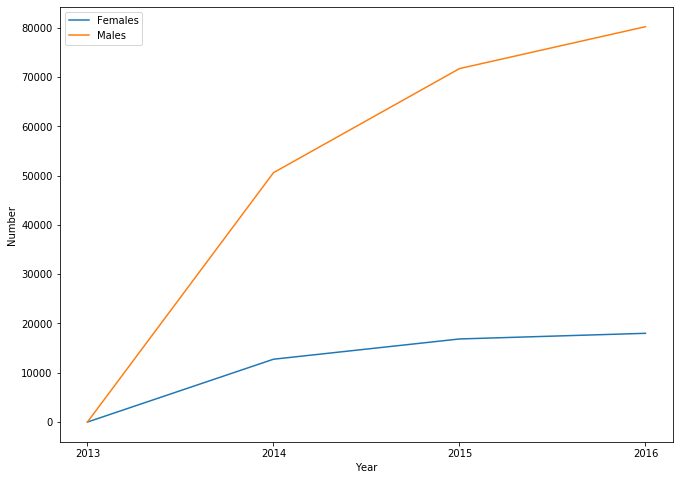

In [8]:
row=graph.run("match (sr: SubReddit)-[r:targets]->(tr: SubReddit) return sr.id,apoc.temporal.format(r.timestamp, 'yyyy') AS year, (r.textProp[22]+r.textProp[26]+r.textProp[27]+r.textProp[28])/4 as F,(r.textProp[37]+r.textProp[30]+r.textProp[24]+r.textProp[25])/4 as M, tr.id").to_data_frame()
df=pd.DataFrame(row)
df = df[df.year!='2017']
ddf = dd.from_pandas(df, npartitions=8)
ddf['gender']=0
str(ddf['gender'])
ddf['gender'] = ddf['gender'].mask(ddf.F >= ddf.M, 'Female').compute()
ddf['gender'] = ddf['gender'].mask(ddf.F < ddf.M, 'Male').compute()
count1time=ddf[ddf['gender'] == 'Female'].groupby(['year']).count().compute().reset_index()
count2time=ddf[ddf['gender'] == 'Male'].groupby(['year']).count().compute().reset_index()
sorted1time = count1time.sort_values(['year'], ascending=True)
sorted2time = count2time.sort_values(['year'], ascending=True)



fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax1.plot(sorted1time['year'], sorted1time['F'], label='Females')
ax1.plot(sorted2time['year'], sorted2time['M'], label='Males')
ax1.legend(loc=2)

plt.ylabel("Number")
plt.xlabel("Year")
plt.show()
fig.savefig('no._ofmale_female_line.png')

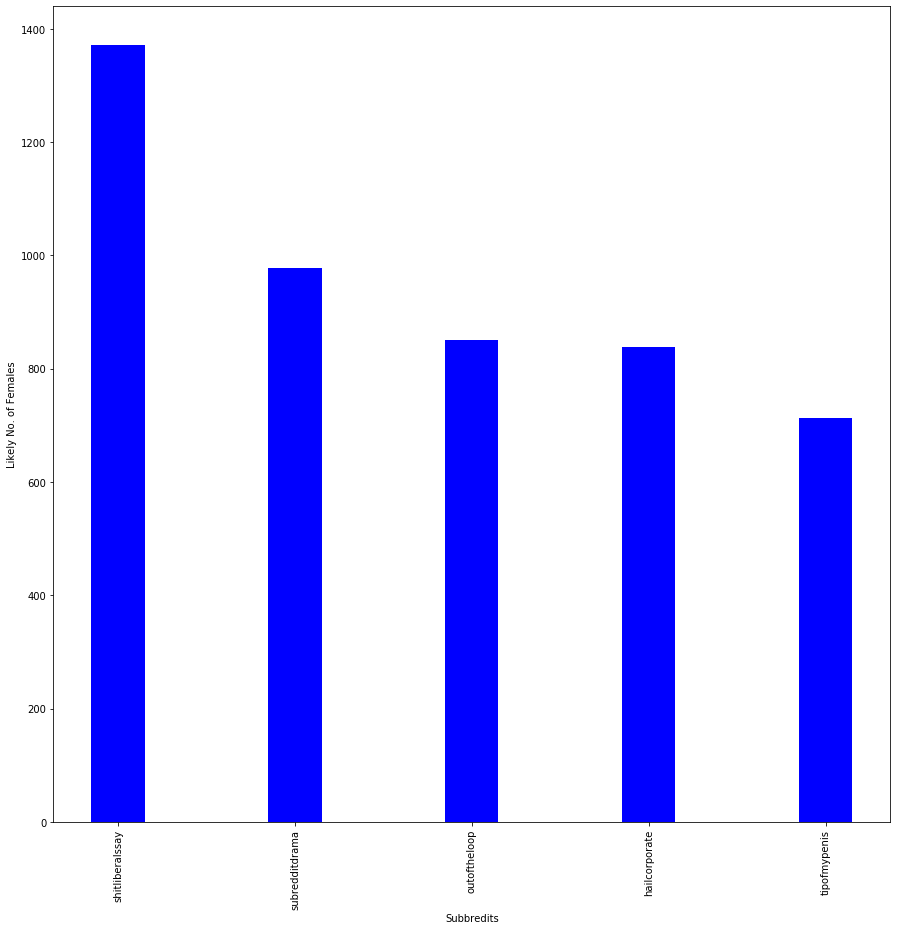

In [17]:
row=graph.run("match (sr: SubReddit)-[r:targets]->(tr: SubReddit) return sr.id, (r.textProp[22]+r.textProp[26]+r.textProp[27]+r.textProp[28])/4 as F,(r.textProp[37]+r.textProp[30]+r.textProp[24]+r.textProp[25])/4 as M, tr.id").to_data_frame()
df=pd.DataFrame(row)
ddf = dd.from_pandas(df, npartitions=8)
ddf['gender']=0
str(ddf['gender'])
ddf['gender'] = ddf['gender'].mask(ddf.F >= ddf.M, 'Female').compute()
ddf['gender'] = ddf['gender'].mask(ddf.F < ddf.M, 'Male').compute()
count1=ddf[ddf['gender'] == 'Female'].groupby(['sr.id','gender']).count().compute().reset_index()
count2=ddf[ddf['gender'] == 'Male'].groupby(['sr.id','gender']).count().compute().reset_index()
final_df= dd.merge(count1[['sr.id','F']], count2[['sr.id','M']], left_on='sr.id', right_on='sr.id')
sorted_final_df = final_df.sort_values(['F'], ascending=False)

test=count1.sum(axis = 0, skipna = True) 
test1=count2.sum(axis = 0, skipna = True) 


fig = plt.figure()
ax = plt.subplot(111)
w = 0.3

ax.bar(sorted_final_df['sr.id'][:5], sorted_final_df['F'][:5], width=w, color='b', align='center')
#ax.bar(sorted_final_df['sr.id'], sorted_final_df['M'], width=w, color='g', align='center')

ax.autoscale(tight=False)
plt.xticks(rotation=90)
plt.ylabel("Likely No. of Females")
plt.xlabel("Subbredits")
plt.show()
fig.savefig('reddits_with_high_no.of_females.png')

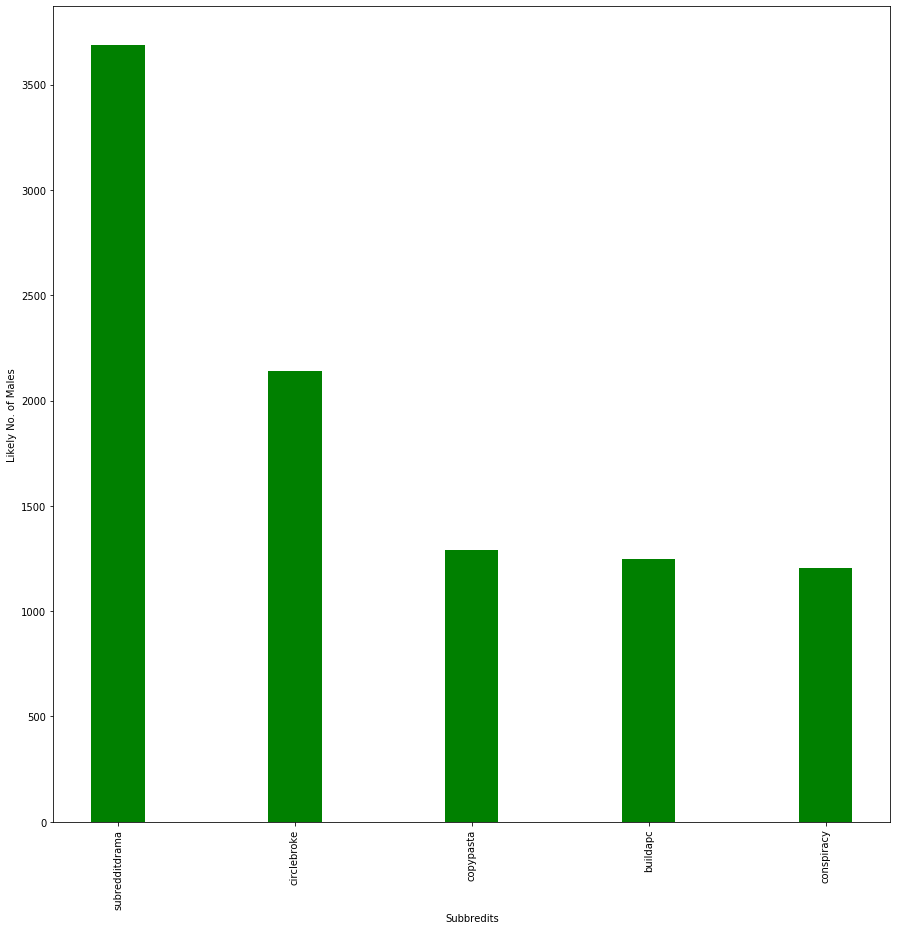

In [25]:
row=graph.run("match (sr: SubReddit)-[r:targets]->(tr: SubReddit) return sr.id, (r.textProp[22]+r.textProp[26]+r.textProp[27]+r.textProp[28])/4 as F,(r.textProp[37]+r.textProp[30]+r.textProp[24]+r.textProp[25])/4 as M, tr.id").to_data_frame()
df=pd.DataFrame(row)
ddf = dd.from_pandas(df, npartitions=8)
ddf['gender']=0
str(ddf['gender'])
ddf['gender'] = ddf['gender'].mask(ddf.F >= ddf.M, 'Female').compute()
ddf['gender'] = ddf['gender'].mask(ddf.F < ddf.M, 'Male').compute()
count1=ddf[ddf['gender'] == 'Female'].groupby(['sr.id','gender']).count().compute().reset_index()
count2=ddf[ddf['gender'] == 'Male'].groupby(['sr.id','gender']).count().compute().reset_index()
final_df= dd.merge(count1[['sr.id','F']], count2[['sr.id','M']], left_on='sr.id', right_on='sr.id')
sorted_final_df = final_df.sort_values(['M'], ascending=False)

test=count1.sum(axis = 0, skipna = True) 
test1=count2.sum(axis = 0, skipna = True) 


fig = plt.figure()
ax = plt.subplot(111)
w = 0.3

#ax.bar(sorted_final_df['sr.id'], sorted_final_df['F'], width=w, color='b', align='center')
ax.bar(sorted_final_df['sr.id'][:5], sorted_final_df['M'][:5], width=w, color='g', align='center')

ax.autoscale(tight=False)
plt.xticks(rotation=90)
plt.ylabel("Likely No. of Males")
plt.xlabel("Subbredits")
plt.show()
fig.savefig('subreddits_with_high_no._of_males.png')

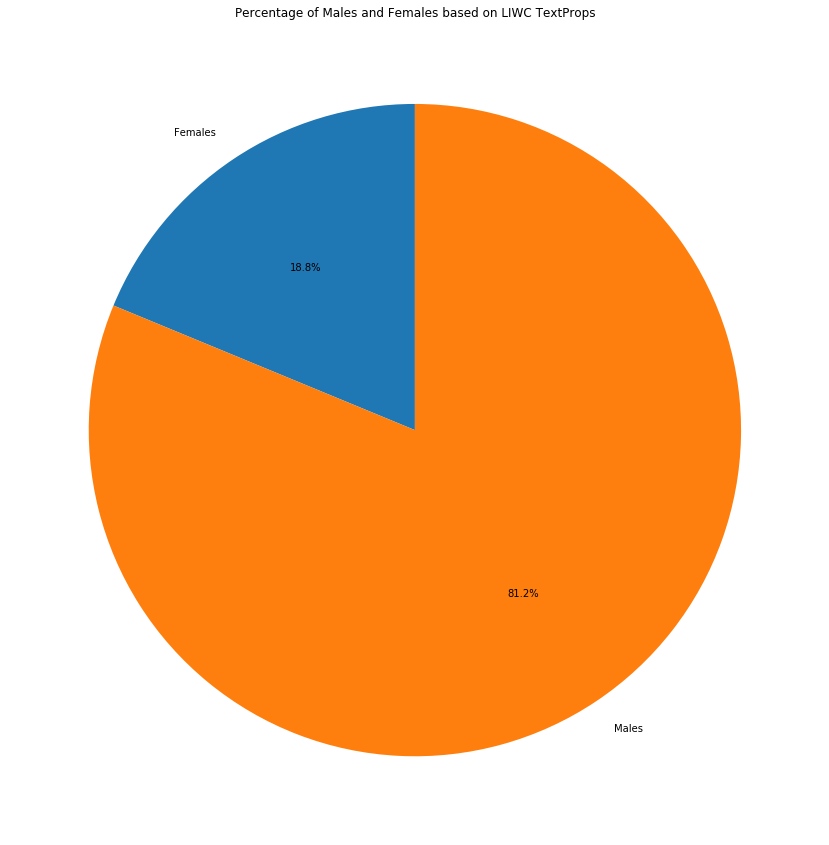

In [19]:
row=graph.run("match (sr: SubReddit)-[r:targets]->(tr: SubReddit) return sr.id, (r.textProp[22]+r.textProp[26]+r.textProp[27]+r.textProp[28])/4 as F,(r.textProp[37]+r.textProp[30]+r.textProp[24]+r.textProp[25])/4 as M, tr.id").to_data_frame()
df=pd.DataFrame(row)
ddf = dd.from_pandas(df, npartitions=8)
ddf['gender']=0
str(ddf['gender'])
ddf['gender'] = ddf['gender'].mask(ddf.F >= ddf.M, 'Female').compute()
ddf['gender'] = ddf['gender'].mask(ddf.F < ddf.M, 'Male').compute()
count1=ddf[ddf['gender'] == 'Female'].groupby(['sr.id','gender']).count().compute().reset_index()
count2=ddf[ddf['gender'] == 'Male'].groupby(['sr.id','gender']).count().compute().reset_index()
final_df= dd.merge(count1[['sr.id','F']], count2[['sr.id','M']], left_on='sr.id', right_on='sr.id')
sorted_final_df = final_df.sort_values(['F'], ascending=False)

test=count1.sum(axis = 0, skipna = True) 
test1=count2.sum(axis = 0, skipna = True) 
total=[test.F,test1.M]
label=['Females','Males']
fig = plt.figure()
plt.pie(total, labels=label, startangle=90, autopct='%.1f%%')
plt.title('Percentage of Males and Females based on LIWC TextProps')
plt.show()
fig.savefig('male_female_%.png')
#https://www.techjunkie.com/demographics-reddit/#Age_and_Gender   71% males use Reddit the results we are getting are close for subbreddits example circlejerkcopypasta has 70%males .

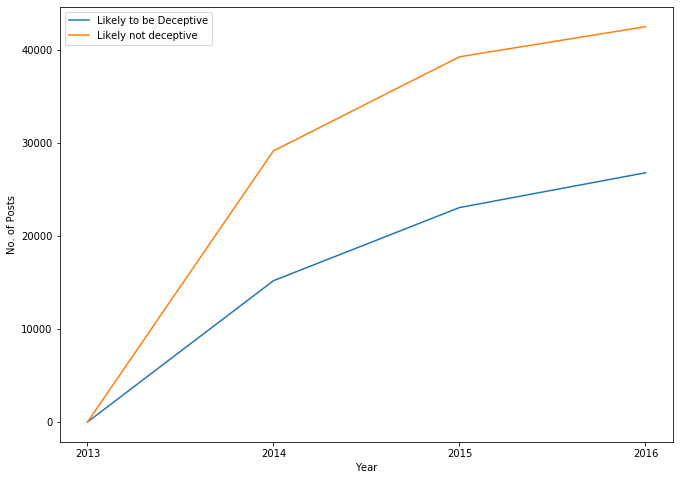

In [20]:
row=graph.run("match (s1:SubReddit)-[r:targets]->(t1:SubReddit) return s1.id, apoc.temporal.format(r.timestamp, 'yyyy') AS year,r.textProp[72] as Motion,r.textProp[49] as negemo,r.textProp[61] as exclusion,r.textProp[24] as firstperson").to_data_frame()
df=pd.DataFrame(row)
df = df[df.year!='2017']
ddf = dd.from_pandas(df, npartitions=8)
motion_mean=ddf["Motion"].mean().compute()
negemo_mean=ddf["negemo"].mean().compute()
exclusion_mean=ddf["exclusion"].mean().compute()
firstperson_mean=ddf["firstperson"].mean().compute()
ddf['deceptive']=0
str(ddf['deceptive'])
filter_mean=((ddf.Motion >= motion_mean) | (ddf.negemo>=negemo_mean)) & ((ddf.exclusion<=exclusion_mean) | (ddf.firstperson<=firstperson_mean))
filter1_mean=((ddf.Motion <= motion_mean) | (ddf.negemo<=negemo_mean)) & ((ddf.exclusion>=exclusion_mean) | (ddf.firstperson>=firstperson_mean))
ddf['deceptive'] = ddf['deceptive'].mask(filter_mean, 'Deceptive').compute()
ddf['deceptive'] = ddf['deceptive'].mask(filter1_mean, 'Not Deceptive').compute()
counttime=ddf[ddf['deceptive'] == 'Deceptive'].groupby(['year']).count().compute().reset_index()
counttime2=ddf[ddf['deceptive'] == 'Not Deceptive'].groupby(['year']).count().compute().reset_index()
sorted1 = counttime.sort_values(['year'], ascending=True)
sorted2 = counttime2.sort_values(['year'], ascending=True)


fig = plt.figure(figsize=(11,8))
ax1 = fig.add_subplot(111)
ax1.plot(sorted1['year'], sorted1['deceptive'], label='Likely to be Deceptive')
ax1.plot(sorted2['year'], sorted2['deceptive'], label='Likely not deceptive')
ax1.legend(loc=2)

plt.ylabel("No. of Posts")
plt.xlabel("Year")
plt.show()
fig.savefig('posts_deceptive_or_not_line.png')

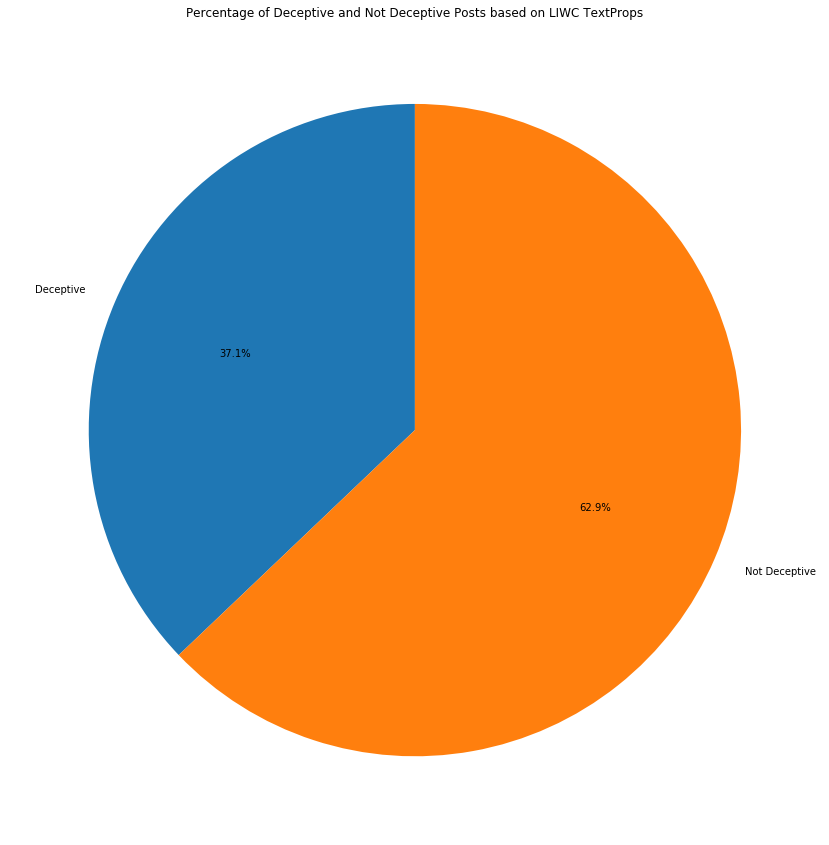

In [26]:
row=graph.run("match (s1:SubReddit)-[r:targets]->(t1:SubReddit) return s1.id, r.textProp[72] as Motion,r.textProp[49] as negemo,r.textProp[61] as exclusion,r.textProp[24] as firstperson").to_data_frame()
df=pd.DataFrame(row)
ddf = dd.from_pandas(df, npartitions=8)
motion_mean=ddf["Motion"].mean().compute()
negemo_mean=ddf["negemo"].mean().compute()
exclusion_mean=ddf["exclusion"].mean().compute()
firstperson_mean=ddf["firstperson"].mean().compute()
ddf['deceptive']=0
str(ddf['deceptive'])
filter_mean=((ddf.Motion >= motion_mean) | (ddf.negemo>=negemo_mean)) & ((ddf.exclusion<=exclusion_mean) | (ddf.firstperson<=firstperson_mean))
filter1_mean=((ddf.Motion <= motion_mean) | (ddf.negemo<=negemo_mean)) & ((ddf.exclusion>=exclusion_mean) | (ddf.firstperson>=firstperson_mean))
ddf['deceptive'] = ddf['deceptive'].mask(filter_mean, 'Deceptive').compute()
ddf['deceptive'] = ddf['deceptive'].mask(filter1_mean, 'Not Deceptive').compute()
count1=ddf[ddf['deceptive'] == 'Deceptive'].groupby(['s1.id']).count().compute().reset_index()
count2=ddf[ddf['deceptive'] == 'Not Deceptive'].groupby(['s1.id']).count().compute().reset_index()
test=count1.sum(axis = 0, skipna = True) 
test1=count2.sum(axis = 0, skipna = True) 
total=[test.deceptive,test1.deceptive]
label=['Deceptive','Not Deceptive']
fig = plt.figure()
plt.pie(total, labels=label, startangle=90, autopct='%.1f%%')
plt.title('Percentage of Deceptive and Not Deceptive Posts based on LIWC TextProps')
plt.show()
fig.savefig('%_of_deceptive_not_deceptive.png')

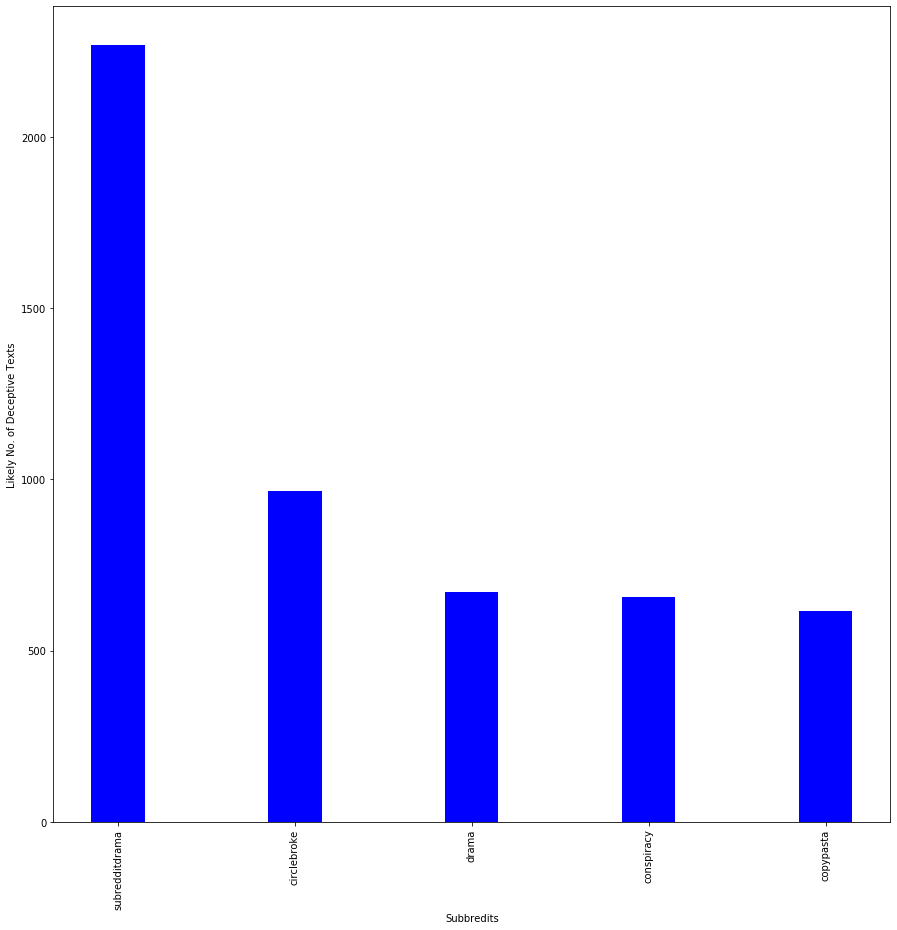

In [29]:
row=graph.run("match (s1:SubReddit)-[r:targets]->(t1:SubReddit) return s1.id, r.textProp[72] as Motion,r.textProp[49] as negemo,r.textProp[61] as exclusion,r.textProp[24] as firstperson").to_data_frame()
df=pd.DataFrame(row)
ddf = dd.from_pandas(df, npartitions=8)
motion_mean=ddf["Motion"].mean().compute()
negemo_mean=ddf["negemo"].mean().compute()
exclusion_mean=ddf["exclusion"].mean().compute()
firstperson_mean=ddf["firstperson"].mean().compute()
ddf['deceptive']=0
str(ddf['deceptive'])
filter_mean=((ddf.Motion >= motion_mean) | (ddf.negemo>=negemo_mean)) & ((ddf.exclusion<=exclusion_mean) | (ddf.firstperson<=firstperson_mean))
filter1_mean=((ddf.Motion <= motion_mean) | (ddf.negemo<=negemo_mean)) & ((ddf.exclusion>=exclusion_mean) | (ddf.firstperson>=firstperson_mean))
ddf['deceptive'] = ddf['deceptive'].mask(filter_mean, 'Deceptive').compute()
ddf['deceptive'] = ddf['deceptive'].mask(filter1_mean, 'Not Deceptive').compute()
count1=ddf[ddf['deceptive'] == 'Deceptive'].groupby(['s1.id']).count().compute().reset_index()
count2=ddf[ddf['deceptive'] == 'Not Deceptive'].groupby(['s1.id']).count().compute().reset_index()
sorted_final_df = count1.sort_values(['deceptive'], ascending=False)
fig = plt.figure()
ax = plt.subplot(111)
w = 0.3

ax.bar(sorted_final_df['s1.id'][:5], sorted_final_df['deceptive'][:5], width=w, color='b', align='center')
#ax.bar(sorted_final_df['sr.id'], sorted_final_df['M'], width=w, color='g', align='center')

ax.autoscale(tight=False)
plt.xticks(rotation=90)
plt.ylabel("Likely No. of Deceptive Texts")
plt.xlabel("Subbredits")
plt.show()
fig.savefig('bar_deceptive_texts_subbreddits.png')

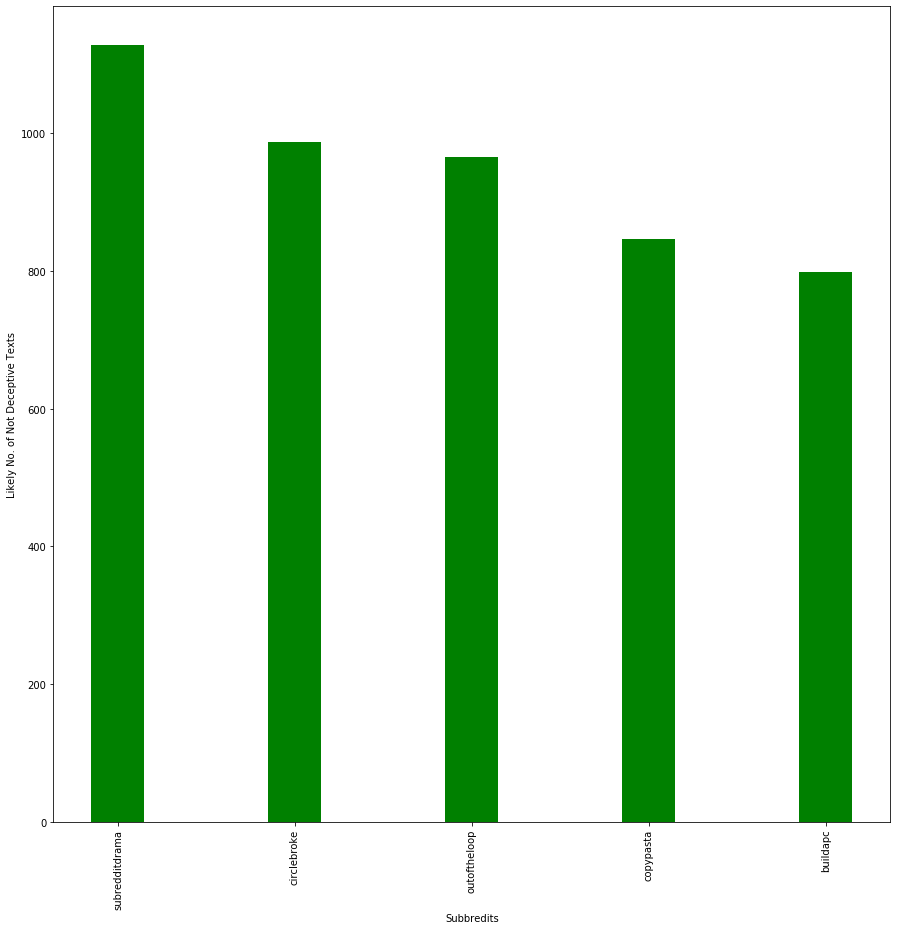

In [30]:
row=graph.run("match (s1:SubReddit)-[r:targets]->(t1:SubReddit) return s1.id, r.textProp[72] as Motion,r.textProp[49] as negemo,r.textProp[61] as exclusion,r.textProp[24] as firstperson").to_data_frame()
df=pd.DataFrame(row)
ddf = dd.from_pandas(df, npartitions=8)
motion_mean=ddf["Motion"].mean().compute()
negemo_mean=ddf["negemo"].mean().compute()
exclusion_mean=ddf["exclusion"].mean().compute()
firstperson_mean=ddf["firstperson"].mean().compute()
ddf['deceptive']=0
str(ddf['deceptive'])
filter_mean=((ddf.Motion >= motion_mean) | (ddf.negemo>=negemo_mean)) & ((ddf.exclusion<=exclusion_mean) | (ddf.firstperson<=firstperson_mean))
filter1_mean=((ddf.Motion <= motion_mean) | (ddf.negemo<=negemo_mean)) & ((ddf.exclusion>=exclusion_mean) | (ddf.firstperson>=firstperson_mean))
ddf['deceptive'] = ddf['deceptive'].mask(filter_mean, 'Deceptive').compute()
ddf['deceptive'] = ddf['deceptive'].mask(filter1_mean, 'Not Deceptive').compute()
count1=ddf[ddf['deceptive'] == 'Deceptive'].groupby(['s1.id']).count().compute().reset_index()
count2=ddf[ddf['deceptive'] == 'Not Deceptive'].groupby(['s1.id']).count().compute().reset_index()
sorted_final_df = count2.sort_values(['deceptive'], ascending=False)
fig = plt.figure()
ax = plt.subplot(111)
w = 0.3

ax.bar(sorted_final_df['s1.id'][:5], sorted_final_df['deceptive'][:5], width=w, color='g', align='center')
#ax.bar(sorted_final_df['sr.id'], sorted_final_df['M'], width=w, color='g', align='center')

ax.autoscale(tight=False)
plt.xticks(rotation=90)
plt.ylabel("Likely No. of Not Deceptive Texts")
plt.xlabel("Subbredits")
plt.show()
fig.savefig('not_deceptive_subbredits.png')